# Modular Addition

In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

## Dataset

In [2]:
def one_hot(p):
    """One-hot encode an integer value in R^p."""
    vec = np.zeros(p)
    vec[0] = 1
    return vec

def generate_template(p, magnitude, exponent):
    weight = magnitude * np.power(np.arange(1, p), -exponent)  # Power-law singular values
    template = np.ones(p)  # Base term (DC component)
    for freq in range(1, p):
        template += weight[freq-1] * np.cos(np.arange(p) * freq / p * 2 * np.pi)
    return template / p

def generate_fixed_template(p):
    # Generate template array from Fourier spectrum
    spectrum = np.zeros(p, dtype=complex)
    
    # Set only three frequencies with specific amplitudes
    spectrum[1] = 10 # Positive frequency
    spectrum[-1] = 10  # Negative frequency (conjugate)
    spectrum[3] = 5 # Second frequency
    spectrum[-3] =  5  # Its conjugate
    spectrum[5] = 2.5  # Third frequency 
    spectrum[-5] = 2.5  # Its conjugate
    
    # Generate signal from spectrum
    template = np.fft.ifft(spectrum).real

    return template

def ModularAdditionDataset(p, template):
    # Initialize data arrays
    X = np.zeros((p * p, 2, p))  # Shape: (p^2, 2, p)
    Y = np.zeros((p * p, p))     # Shape: (p^2, p)
    
    # Generate the dataset
    idx = 0
    for a in range(p):
        for b in range(p):
            q = (a + b) % p  # a + b mod p
            X[idx, 0, :] = np.roll(template, a)
            X[idx, 1, :] = np.roll(template, b)
            Y[idx, :] = np.roll(template, q)
            idx += 1
            
    return X, Y

## Architecture

In [3]:
class TwoLayerNet(nn.Module):
    def __init__(self, p, hidden_size, init_scale=1.0):
        super(TwoLayerNet, self).__init__()
        
        # Store dimensions
        self.p = p
        self.hidden_size = hidden_size
        self.init_scale = init_scale
        
        # Initialize parameters 
        self.U = nn.Parameter(self.init_scale * torch.randn(hidden_size, p) / np.sqrt(2*p))
        self.V = nn.Parameter(self.init_scale * torch.randn(hidden_size, p) / np.sqrt(2*p))
        self.W = nn.Parameter(self.init_scale * torch.randn(hidden_size, p) / np.sqrt(p))

    def forward(self, x):
        x1 = x[:, :self.p] @ self.U.T
        x2 = x[:, self.p:] @ self.V.T
        x_out = ((x1 + x2)**2) @ self.W        
        return x_out

In [4]:
seed = 30  # or any integer you like
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if using GPU

# Data Generation using the new function
p = 20  # Modulus

# Get base vector
template = generate_fixed_template(p)

# Mean center template
template -= np.mean(template)

# Generate dataset using numpy
X, Y = ModularAdditionDataset(p, template)
X_train = torch.tensor(X, dtype=torch.float32).view(-1, 2 * p).cuda()
Y_train = torch.tensor(Y, dtype=torch.float32).cuda()

In [7]:
lr = 0.01
mom = 0.9
init_scale=2e-3
hidden_size = 6 * 3

costmin_lr = 0.01
utilmax_lr = 10

## Optimization

In [ ]:
def train(model, X_train, Y_train, optimizer, nsteps=100):
    model.train()
    loss_history = {}
    param_history = {}

    for t in tqdm(range(nsteps)):
        optimizer.zero_grad()
        residual = (Y_train - model(X_train))
        loss = (residual**2).mean()
        loss_history[t] = loss.item()
        if loss.item() > 1e5:
            assert False
        if t % nsteps//100 == 0:
            param_history[t] = {
                "U": model.U.detach().cpu().clone(),
                "V": model.V.detach().cpu().clone(),

                "W": model.W.detach().cpu().clone()
            }            
        loss.backward()
        optimizer.step()
        
    return loss_history, param_history # Return loss history for plotting

model = TwoLayerNet(p=p, hidden_size=hidden_size,
                    init_scale=init_scale).cuda()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=mom)
nsteps = 200_000
loss_history, param_history = train(model, X_train, Y_train, optimizer, nsteps=nsteps)

with open("loss_history.pickle", "wb") as f:
    pickle.dump(loss_history, f)

with open("param_history.pickle", "wb") as f:
    pickle.dump(param_history, f)

100%|██████████| 200000/200000 [05:21<00:00, 621.16it/s]


## AGF

In [5]:
with open("loss_history.pickle", "rb") as f:
    loss_history = pickle.load(f)
with open("param_history.pickle", "rb") as f:
    param_history = pickle.load(f)

if loss_history==None or param_history==None:
    print("Must first generate true GD trajectory")

In [8]:
class ModsumSubNetwork(nn.Module):
    
    def __init__(self, d_in, d_out, init_scale):
        super().__init__()
        assert d_in%2 == 0
        self.p = d_in // 2
        self.u = nn.Linear(self.p, 1, bias=False)
        self.v = nn.Linear(self.p, 1, bias=False)
        self.w = nn.Linear(1, d_out, bias=False)
        with torch.no_grad():
            self.w.weight.mul_(init_scale)
            self.u.weight.mul_(init_scale)
            self.v.weight.mul_(init_scale)
        self.active = False
        self.util_acc = 0
        self.c_a = 1/self.get_norm() - 1
        
        self.normalize()
        
    def get_norm(self):
        sqnorm = lambda x: torch.linalg.norm(x.weight)**2
        norm = torch.sqrt(sqnorm(self.w) + sqnorm(self.u) + sqnorm(self.v))
        return norm
    
    def reinitialize(self, u, v, w):
        with torch.no_grad():
            self.u.weight.copy_(u)
            self.v.weight.copy_(v)
            self.w.weight.copy_(w)
        self.c_a = 1/self.get_norm() - 1
    
    def forward(self, x):
        x1 = x[:, :self.p]
        x2 = x[:, self.p:]
        return self.w((self.u(x1) + self.v(x2))**2)
    
    def normalize(self):
        norm = self.get_norm()
        with torch.no_grad():
            self.w.weight.div_(norm)
            self.u.weight.div_(norm)
            self.v.weight.div_(norm)
    
    def utility_step(self, x, residual, learning_rate):
        f_i = self(x)
        util = torch.einsum('nd,nd->n',  f_i, residual).mean()
        self.util_acc += 3 * learning_rate * util.item()
        norm_th = 1/(1 + self.c_a - self.util_acc)
        
        util.backward()
        with torch.no_grad():
            self.w.weight += norm_th * learning_rate * self.w.weight.grad
            self.u.weight += norm_th * learning_rate * self.u.weight.grad
            self.v.weight += norm_th * learning_rate * self.v.weight.grad
            self.w.weight.grad.zero_()
            self.u.weight.grad.zero_()
            self.v.weight.grad.zero_()
            self.normalize()


class ModsumNetwork(nn.Module):
    
    def __init__(self, d_in, d_out, init_scale, width=100):
        super().__init__()
        neurons = [ModsumSubNetwork(d_in, d_out, init_scale) for _ in range(width)]
        self.neurons = nn.ModuleList(neurons)
        self.set_mode("utilmax")
    
    def load_init(self, U, V, W):
        for i, n in enumerate(self.neurons):
            u, v, w = U[i], V[i], W[i][:, None]
            n.reinitialize(u, v, w)
            
    def set_mode(self, mode):
        if mode not in ["utilmax", "costmin"]:
            raise ValueError("mode must be utilmax or costmin")
        self.mode = mode
        for neuron in self.neurons:
            grad_on = (mode=="utilmax") ^ neuron.active
            for param in neuron.parameters():
                param.requires_grad = grad_on
    
    def forward(self, x):
        if not np.any([n.active for n in self.neurons]):
            return 0
        else:
            outputs = torch.stack([neuron(x) for neuron in self.neurons if neuron.active], dim=0)
            return torch.sum(outputs, dim=0)


def train_agf(X_train, Y_train, init_sz=1e-3, agf_steps=5, from_init=None,
              utilmax_lr=1, costmin_lr=1, costmin_maxiter=2_000, costmin_grad_thresh=1e-1):
    d_in, d_out = X_train.shape[-1], Y_train.shape[-1]
    if from_init:
        U, V, W = from_init["U"], from_init["V"], from_init["W"]
        assert d_in == U.shape[1]*2
        assert d_out == W.shape[1]
        width = U.shape[0]
        net = ModsumNetwork(d_in, d_out, init_sz, width=width).cuda()
        net.load_init(U, V, W)
    else:
        net = ModsumNetwork(d_in, d_out, init_sz, width=agf_steps).cuda()
    X_train.requires_grad = False
    
    def update_results(results, t):
        results["t"].append(t)
        residual = (Y_train - net(X_train))
        residual = residual.detach()
        results["residuals"].append(residual)
        loss = (residual**2).mean().item()
        results["losses"].append(loss)
        results["models"].append(net.state_dict())
        
    results = {
        "t": [],
        "residuals": [],
        "losses": [],
        "models": [],
    }
    t = 0
    update_results(results, t)
    for _ in tqdm(range(agf_steps)):
        residual = (1/d_out) * 2*(Y_train - net(X_train))
        residual = residual.detach()
        iters = 0
        while net.mode == "utilmax":
            for n in net.neurons:
                if n.active:
                    continue
                n.utility_step(X_train, residual, utilmax_lr)
                if n.util_acc > n.c_a:
                    n.active = True
                    net.set_mode("costmin")
                    break
            iters += 1
        t += iters
            
        optimizer = torch.optim.SGD(net.parameters(), lr=costmin_lr, momentum=0.9)
        iters = 0
        while net.mode == "costmin":
            optimizer.zero_grad(set_to_none=False)
            residual = (Y_train - net(X_train))
            loss = (residual**2).mean()
            loss.backward()
            if iters%100 == 0:
                with torch.no_grad():
                    grad_norm = np.sqrt(sum([torch.norm(p.grad)**2 for p in net.parameters()]).item())
                rel_grad = grad_norm/loss.item()
                if rel_grad < costmin_grad_thresh:
                    net.set_mode("utilmax")
                elif rel_grad*costmin_lr > 1:
                    raise ValueError
            if iters > costmin_maxiter:
                net.set_mode("utilmax")
            optimizer.step()
            iters += 1
        update_results(results, t)
        print(f"loss: {loss.item():.5f}")
    
    return results

In [ ]:
results = train_agf(X_train, Y_train, init_sz=init_scale, agf_steps=11, from_init=param_history[0],
                    utilmax_lr=utilmax_lr, costmin_lr=costmin_lr, costmin_grad_thresh=3.8e-2)

  9%|▉         | 1/11 [00:04<00:44,  4.41s/it]

loss: 0.59962


 18%|█▊        | 2/11 [00:07<00:30,  3.39s/it]

loss: 0.41270


 27%|██▋       | 3/11 [00:09<00:23,  2.92s/it]

loss: 0.28552


 36%|███▋      | 4/11 [00:14<00:27,  3.93s/it]

loss: 0.24469


 45%|████▌     | 5/11 [00:20<00:27,  4.52s/it]

loss: 0.15730


## Plots

In [11]:
def smart_tick_formatter(x, pos):
    abs_x = abs(x)

    if x == 0:
        return "0"
    elif abs_x >= 1e4 or abs_x < 1e-3:
        return f"{x:.1e}"  # scientific notation
    elif x == int(x):
        return f"{x:.0f}"
    elif 1 <= x and x <= 10:
        return f"{x:.1f}"
    else:
        return f"{x:.2f}"

def style_axes(ax, numyticks=5, numxticks=5):
    # formatter = FuncFormatter(smart_tick_formatter)

    ax.tick_params(axis="y", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True, direction='out', length=7, width=1.5, pad=8, labelsize=24)
    # ax.yaxis.set_major_formatter(formatter)

    ax.tick_params(axis="x", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True, direction='out', length=7, width=1.5, pad=8, labelsize=24)
    # ax.xaxis.set_major_formatter(formatter)


    if ax.get_yscale() == 'linear':
        ax.ticklabel_format(style='sci', axis='y', scilimits=(-2, 2))
    
    if ax.get_xscale() == 'linear':
        ax.ticklabel_format(style='sci', axis='x', scilimits=(-2, 2))

    ax.xaxis.offsetText.set_fontsize(20)
    ax.grid()

    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    for spine in ["left", "bottom"]:
        ax.spines[spine].set_linewidth(3)

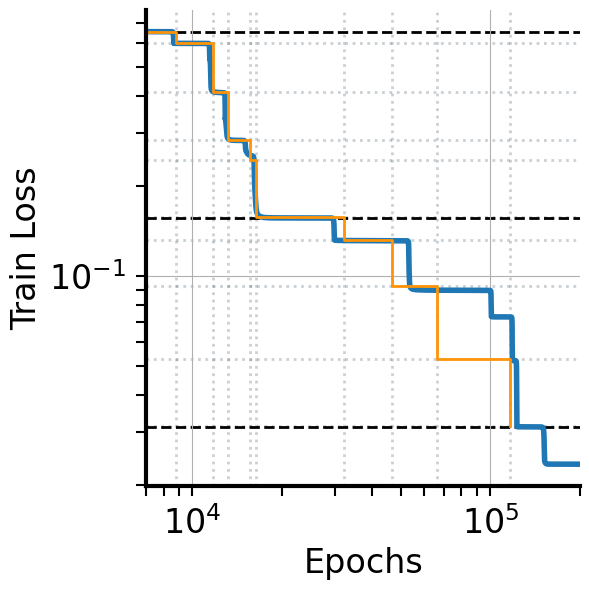

In [13]:
def get_power(points):
    p = len(points)
    num_coefficients = (p // 2) + 1
    
    # Perform FFT and calculate power spectrum
    ft = np.fft.fft(points) # Could consider using np.fft.rfft which is designed for real valued input.
    power = np.abs(ft[:num_coefficients])**2 / p
    
    # Double power for frequencies strictly between 0 and Nyquist (Nyquist is not doubled if p is even)
    if p % 2 == 0:  # p is even, Nyquist frequency at index num_coefficients - 1
        power[1:num_coefficients - 1] *= 2
    else:  # p is odd, no Nyquist frequency
        power[1:] *= 2

    # Confirm the power sum approximates the squared norm of points
    total_power = np.sum(power)
    norm_squared = np.linalg.norm(points)**2
    if not np.isclose(total_power, norm_squared, rtol=1e-3):
        print(f"Warning: Total power {total_power:.3f} does not match norm squared {norm_squared:.3f}")

    return np.arange(num_coefficients), power

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(list(loss_history.values()), lw=4)

for lossval in results["losses"]:
    ax.axhline(lossval, alpha=0.3, ls=":", color="xkcd:slate", zorder=-4, lw=2)

f = utilmax_lr / (lr/(1-mom))
for t in results["t"]:
    ax.axvline(f*t, alpha=0.3, ls=":", color="xkcd:slate", zorder=-4, lw=2)

ax.step(f*np.array(results["t"]), results["losses"], where="post",
        lw=2, color="xkcd:tangerine")

# === Compute power spectrum of template ===
freq, power = get_power(template)
valid = power > 1e-20
freq, power = freq[valid], power[valid]
sorted_idx = np.argsort(-power)
freq, power = freq[sorted_idx], power[sorted_idx]

alpha_values = [np.sum(power[k:]) for k in range(len(power))]
coef = 1 / p
for k, alpha in enumerate(alpha_values):
    ax.axhline(y=coef * alpha, color='black', linestyle='--', linewidth=2, zorder=-2)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(7e3, 2e5)
ax.set_xlabel('Epochs', fontsize=24)
ax.set_ylabel('Train Loss', fontsize=24)

style_axes(ax)
plt.tight_layout()
plt.show()

In [14]:
f*np.array(results["t"])

array([     0.,   8800.,  11700.,  13200.,  15600.,  16400.,  32200.,
        46600.,  66000., 116500.])